## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [84]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [85]:
device

'cuda:0'

In [86]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [87]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [88]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [89]:
len(fmnist_dataset_test)

10000

In [90]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [91]:
train_iter = iter(train_loader)

In [92]:
images, labels = train_iter.next()

In [93]:
labels.shape

torch.Size([128])

In [94]:
images.shape

torch.Size([128, 1, 28, 28])

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [103]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(500, 100),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(100, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [96]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
           Sigmoid-3                  [-1, 500]               0
Total params: 392,500
Trainable params: 392,500
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.50
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


Your experiments come here:

In [97]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here

**<font color=blue>Observations:</font>**

- Disclaimer: The function train_model above is largely based on the function with the same name used during Seminar of week 9. 

In [98]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        # Turn on the training mode.
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            
            # 1) zero the grads
            opt.zero_grad()
            
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 2) Do forward pass
            out = model(X_batch)

            # 3) Compute loss
            loss = loss_fn(out, y_batch)

            # 4) Compute gradients (backward pass)
            loss.backward()
            
            # 5) Compute gradient step (with Adam) 
            opt.step()

            ep_train_loss.append(loss.item())
            
            

        # Turn of training mode.
        model.train(False) # disable dropout / use moving averages for batch_norm
        with torch.no_grad(): # torch.no_grad() in order to save memory.
            for X_batch, y_batch in val_loader:

                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # 1) Compute probas
                out = model(X_batch)

                # 2) Compute loss
                loss = loss_fn(out, y_batch)
                ep_val_loss.append(loss.item())

                # 3) Compute predictions
                y_pred = out.max(dim=1)[1]### YOUR CODE HERE
                
                # 4) Compute accuracy
                ep_val_accuracy.append(np.sum((y_pred.cpu() == y_batch.cpu()).numpy().astype(float))/len(y_batch))

        # print the results for this epoch:
        # print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        # print(f"\t  training loss: {train_loss[-1]:.6f}")
        # print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        # print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [99]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='test')
    axes[0].legend()

    axes[1].set_title('Test accuracy')
    axes[1].plot(val_accuracy)

In [100]:
n_epochs = 30
train_loss, test_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

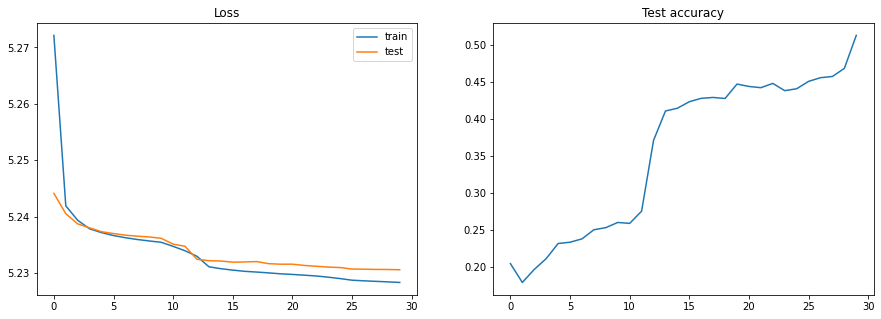

In [101]:
plot_train_process(train_loss, test_loss, val_accuracy)

In [102]:
val_accuracy[-1]

0.51240234375

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Conclusions:
_Write down small report with your conclusions and your ideas._